In [399]:
import os
import sys
import importlib
sys.path.append('..')

In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.stats import (
    rankdata,
    norm
)

In [401]:
import src.config
importlib.reload(src.config)

<module 'src.config' from 'd:\\cqf-cds-pricing\\notebooks\\..\\src\\config.py'>

---

### **INPUTS**

In [402]:
# Spread measure to work with: 'delta' or 'level'
spread_measure = 'delta'
k = 5 # k-th to default


In [403]:
# Field mappings:
field_mappings = {
    'delta': 'cds_delta',
    'level': 'cds_1y_spread_bps'
}

In [404]:
n_sims = 100000                  # Number of simulations
recovery_rate = 0.4             # Assumed recovery rate for CDS pricing

---

### **Functions**

In [405]:
def calc_cdf(x):
    """Calculate the empirical CDF of a 1D array x."""
    x = x.dropna()
    n = len(x)
    x_sorted = np.sort(x)
    y_vals = np.arange(1, n + 1) / (n + 1) # use (n + 1) to avoid reaching 1.0 exactly
    return x_sorted, y_vals

In [406]:
def plot_scatter_matrix(df, spread_measure):
    """Plot scatter matrix for the given DataFrame and spread measure."""
    scatter_matrix(
        df,
        figsize=(10, 10),
        diagonal='hist',
        color='darkgreen' if spread_measure == 'level' else 'darkgreen',
        hist_kwds={"color": "darkgreen" if spread_measure == 'level' else "darkgreen"}
    )
    plt.suptitle(f"Pairwise CDS Spread {spread_measure.upper()} Relationships", y=1.02)
    plt.tight_layout()
    plt.show()

In [407]:
class BootStrapper:
    """Simple piecewise-constant hazard bootstrap from CDS spreads (approx)."""
    def __init__(self, tenors: np.ndarray, spreads: np.ndarray, recovery_rate=0.0):
        self.tenors = tenors
        self.spreads = spreads / 10000  # Convert bps to decimal
        self.R = recovery_rate
        self.lgd = 1 - self.R
    
    def bootstrap(self) -> np.ndarray:
        """Perform bootstrapping to get piecewise hazard rates."""
        tenors = self.tenors
        spreads = self.spreads
        lgd = self.lgd
        avg_haz = spreads / lgd
        haz = [0.0] * len(tenors)
        haz[0] = spreads[0] / lgd  # Initial hazard rate - set equal to first spread / LGD
        for i in range(1, len(tenors)):
            delta_t = tenors[i] - tenors[i - 1]
            hazard_rate = (
                    (avg_haz[i] * tenors[i]) - (avg_haz[i-1] * tenors[i - 1])
                ) / delta_t

            haz[i] = hazard_rate

        return np.array(haz)

In [408]:
def time_to_default(u: float, haz_rates: np.ndarray, tenors: np.ndarray) -> float:
    """
    Scalar inversion: U -> default time tau using piecewise-constant hazard rates.
    Returns np.inf if no default by last tenor.
    """

    h = haz_rates
    t = tenors
    dt = np.diff(np.r_[0.0, t])
    H = np.cumsum(h * dt)
    y = -np.log(1.0 - u)

    j = int(np.searchsorted(H, y, side="left"))
    if j >= len(H):
        return np.inf

    H_prev = 0.0 if j == 0 else H[j - 1]
    t_prev = 0.0 if j == 0 else t[j - 1]
    return t_prev + (y - H_prev) / h[j]


In [409]:
def kth_to_default_df(ttd_df, tickers, k):
    """
    ttd_df : DataFrame with time-to-default (or inf)
    tickers: list of name columns (e.g. ["BA","IBM","JPM","T","XOM"])
    k       : k-th to default (1 <= k <= len(tickers))
    """
    X = ttd_df.loc[:, tickers].to_numpy()
    return np.sort(X, axis=1)[:, k-1]

In [410]:
class CDSPricing:
    """Class for pricing k-th to default CDS."""
    def __init__(self, time_to_default: np.array, term: float, recovery_rate=0.0):
        n_sims = len(time_to_default)
        self.tau = time_to_default
        self.T = float(term)
        self.R = float(recovery_rate)
        self.lgd = 1 - self.R
        

    def _default_leg(self) -> np.array:
        L = self.lgd
        tau = self.tau
        T = self.T
        return L * (tau <= T).astype(float)
    
    def _unit_premium_leg(self) -> np.array:
        tau = self.tau
        T = self.T
        return np.minimum(tau, T)
    
    def scenario_prices(self) -> np.array:
        payout = self._default_leg()       
        unit_premium = self._unit_premium_leg()
        prices = np.where(
            unit_premium > 0.0,
            payout / unit_premium * 10000,  # in bps
            np.inf
        )
        return prices
    
    def price(self):
        payout = self._default_leg()       
        unit_premium = self._unit_premium_leg()
        if np.sum(unit_premium <= 0.0) > 0:         # If unit premium <= 0 means default already happened.
            return np.inf
        
        return float(payout.mean() /unit_premium.mean()) * 10000  # in bps

---

In [411]:
tickers_dict = src.config.TICKERS
tickers = list(tickers_dict.values())

---

## **1. RAW HISTORICAL CREDIT DEFAULT SPREADS**

In [412]:
cds_levels_df = (
    pd.read_csv('../data/synthetic_cds_1y_monthly_to_2025-12-31.csv')
    .loc[lambda df: df['equity_ticker'].isin(tickers)]
)
cds_levels_df['date'] = pd.to_datetime(cds_levels_df['date'])

cds_levels_df = cds_levels_df.sort_values(['equity_ticker', 'date'])

cds_levels_df["cds_delta"] = (
    cds_levels_df
        .groupby("equity_ticker")["cds_1y_spread_bps"]
        .diff()
)

values = field_mappings[spread_measure]

cds_df = cds_levels_df \
    .reset_index(drop=True) \
    .dropna(subset=[values]) \
    .pivot(
        index='date',
        columns='equity_ticker',
        values=values
    )

cds_df.index.name = None
cds_df.columns.name = None

In [413]:
display(cds_df.head())

,BA,IBM,JPM,T,XOM
2016-02-29,-1.5,-0.5,0.2,3.7,3.0
2016-03-31,-0.1,-0.7,-4.0,-0.8,3.4
2016-04-30,3.0,1.7,4.5,-0.8,0.5
2016-05-31,1.6,1.5,5.5,3.0,7.3
2016-06-30,-5.6,0.0,-1.9,-3.3,-0.1


In [414]:
# Calculate the Empirical CDFs from raw delta spreads.
ecdf_raw = {}

for col in cds_df.columns:

    x_sorted, y_vals = calc_cdf(cds_df[col])

    ecdf_raw[col] = {
        "cds": x_sorted,
        "ecdf": y_vals
    }

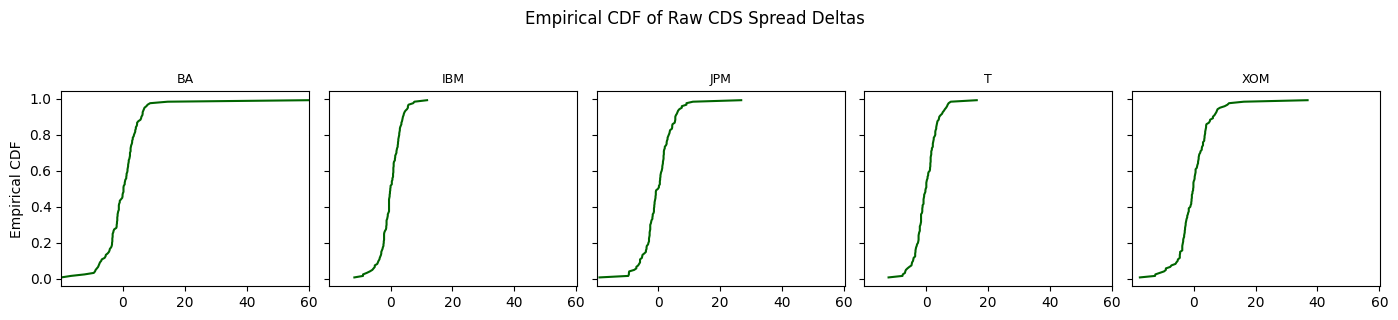

In [415]:
# Plot the Raw Empirical CDFs of raw delta spreads
cols = list(ecdf_raw.keys())

# global x-limits across all names - 
# # needed to keep the same range for delta spreads for comparison across names
all_vals = np.concatenate(
    [ecdf_raw[col]['cds'] for col in ecdf_raw]
)
xmin, xmax = all_vals.min(), all_vals.max()

fig, axes = plt.subplots(1, len(cols), figsize=(14, 3), sharey=True)

for ax, col in zip(axes, cols):

    x_sorted = ecdf_raw[col]['cds']
    ecdf = ecdf_raw[col]['ecdf']

    ax.plot(x_sorted, ecdf, color="darkgreen")
    ax.set_title(col, fontsize=9)
    ax.set_xlim(xmin, xmax)

axes[0].set_ylabel("Empirical CDF")
fig.suptitle("Empirical CDF of Raw CDS Spread Deltas", y=1.05)

plt.tight_layout()
plt.show()

---

## **2. ECDF TRANSFORMED TO UNIFORMS**

In [416]:
# Compute ranks of the delta spreads and convert to uniform variables
# Using a consolidated dataframe for all names

u_df = pd.DataFrame(index=cds_df.index)

for col in cds_df.columns:

    x = cds_df[col]
    pos_not_nan = x.notna()
    n = pos_not_nan.sum()

    ranks = rankdata(x[pos_not_nan], method='average')
    u = ranks / (n + 1)
    u_df.loc[pos_not_nan, col] = u

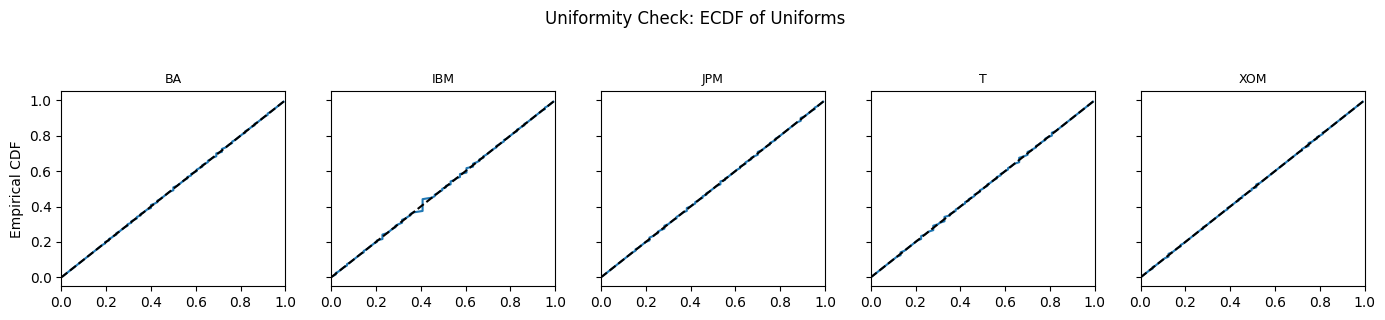

In [417]:
cols = u_df.columns
fig, axes = plt.subplots(1, len(cols), figsize=(14, 3), sharey=True)

for ax, col in zip(axes, cols):
    u = u_df[col].dropna().values
    u_sorted = np.sort(u)
    n = len(u_sorted)

    ax.plot(u_sorted, np.arange(1, n + 1) / (n + 1))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(col, fontsize=9)
    ax.set_xlim(0, 1)

axes[0].set_ylabel("Empirical CDF")
fig.suptitle("Uniformity Check: ECDF of Uniforms", y=1.05)

plt.tight_layout()
plt.show()

---

## **3. CORRELATION MATRIX**

#### **Correlation between CDS spreads**

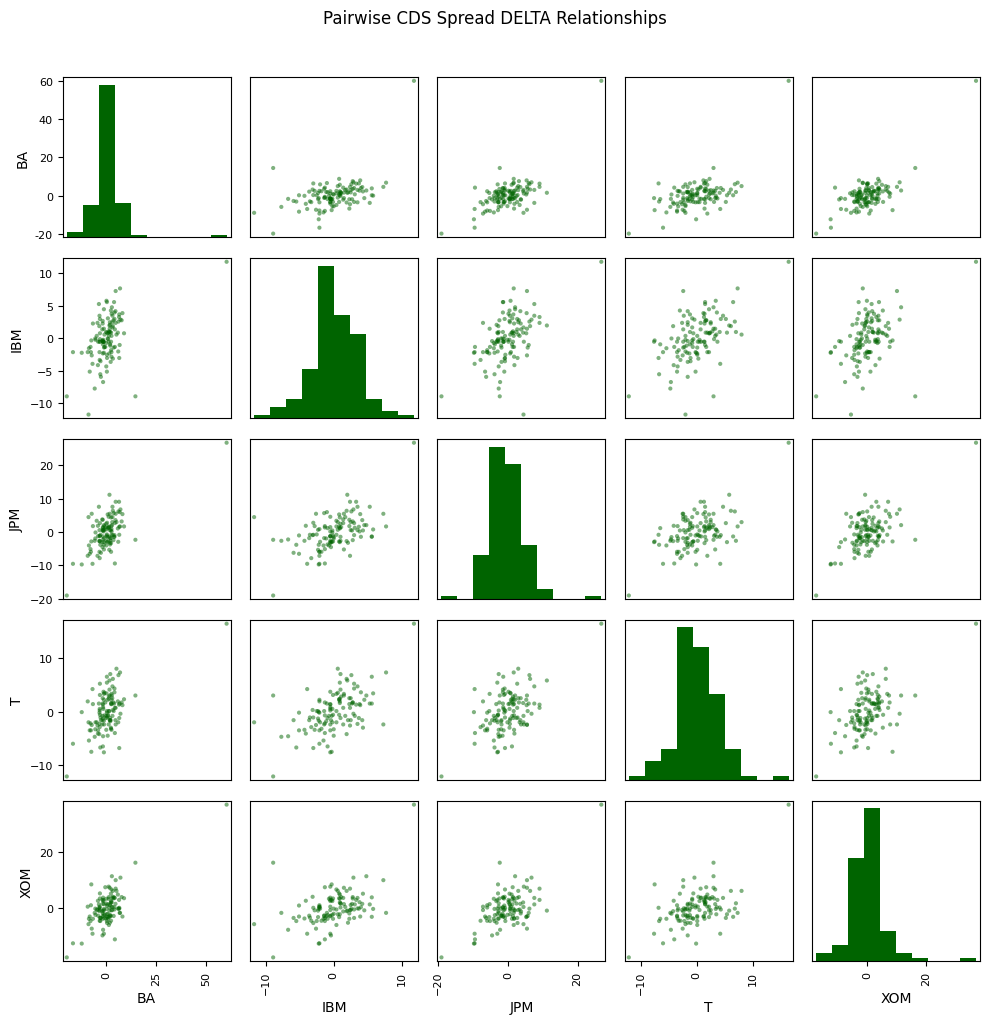

In [418]:
plot_scatter_matrix(cds_df, spread_measure)

In [419]:
cds_corr_df = cds_df.corr()
display(cds_corr_df)

,BA,IBM,JPM,T,XOM
BA,1.000000,0.479482,0.663345,0.573691,0.718013
IBM,0.479482,1.000000,0.526404,0.535165,0.449993
JPM,0.663345,0.526404,1.000000,0.526425,0.611855
T,0.573691,0.535165,0.526425,1.000000,0.513335
XOM,0.718013,0.449993,0.611855,0.513335,1.000000


#### **Correlation between uniforms**

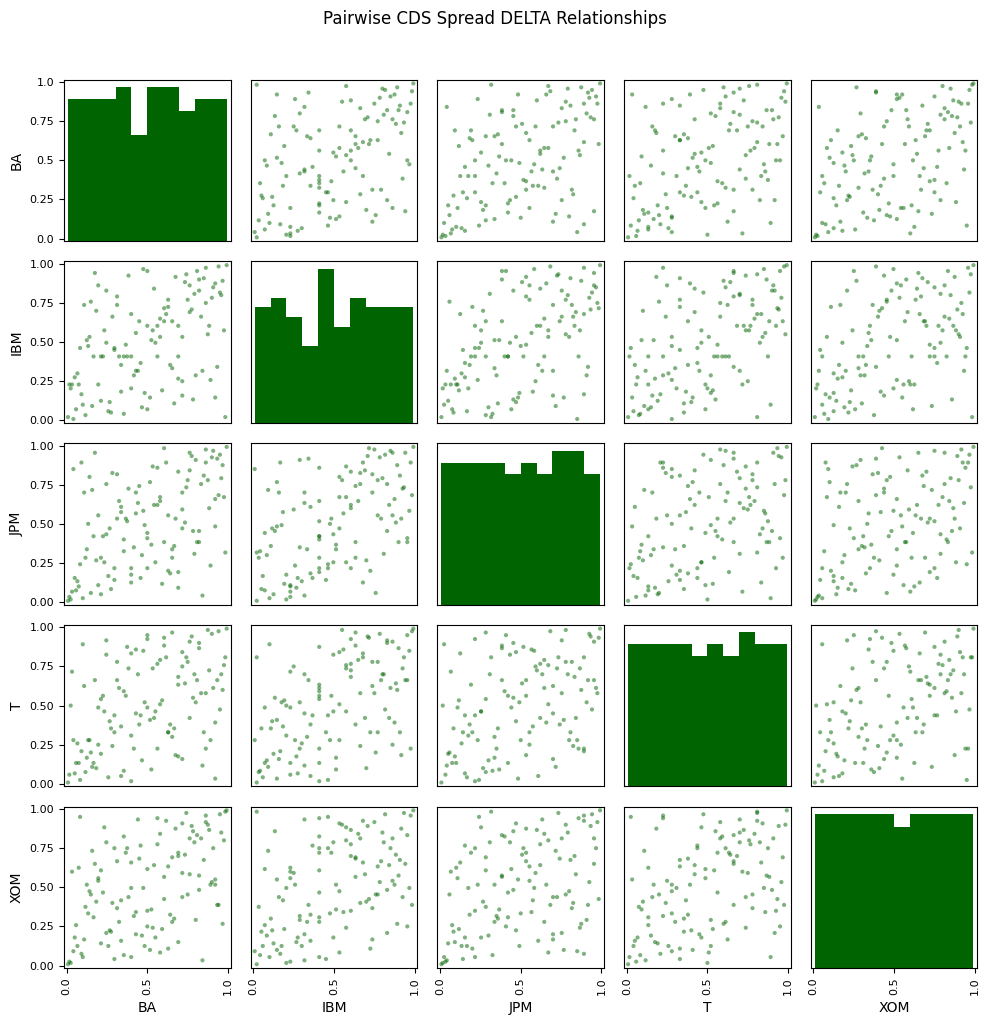

In [420]:
u_joint_df = u_df.dropna(axis=0)

plot_scatter_matrix(u_joint_df, spread_measure)

In [421]:
u_corr_df = u_joint_df.corr()
display(u_corr_df)

,BA,IBM,JPM,T,XOM
BA,1.000000,0.410618,0.437693,0.409732,0.430527
IBM,0.410618,1.000000,0.478839,0.485872,0.426661
JPM,0.437693,0.478839,1.000000,0.363539,0.353023
T,0.409732,0.485872,0.363539,1.000000,0.391522
XOM,0.430527,0.426661,0.353023,0.391522,1.000000


#### **Correlation between standard normals**

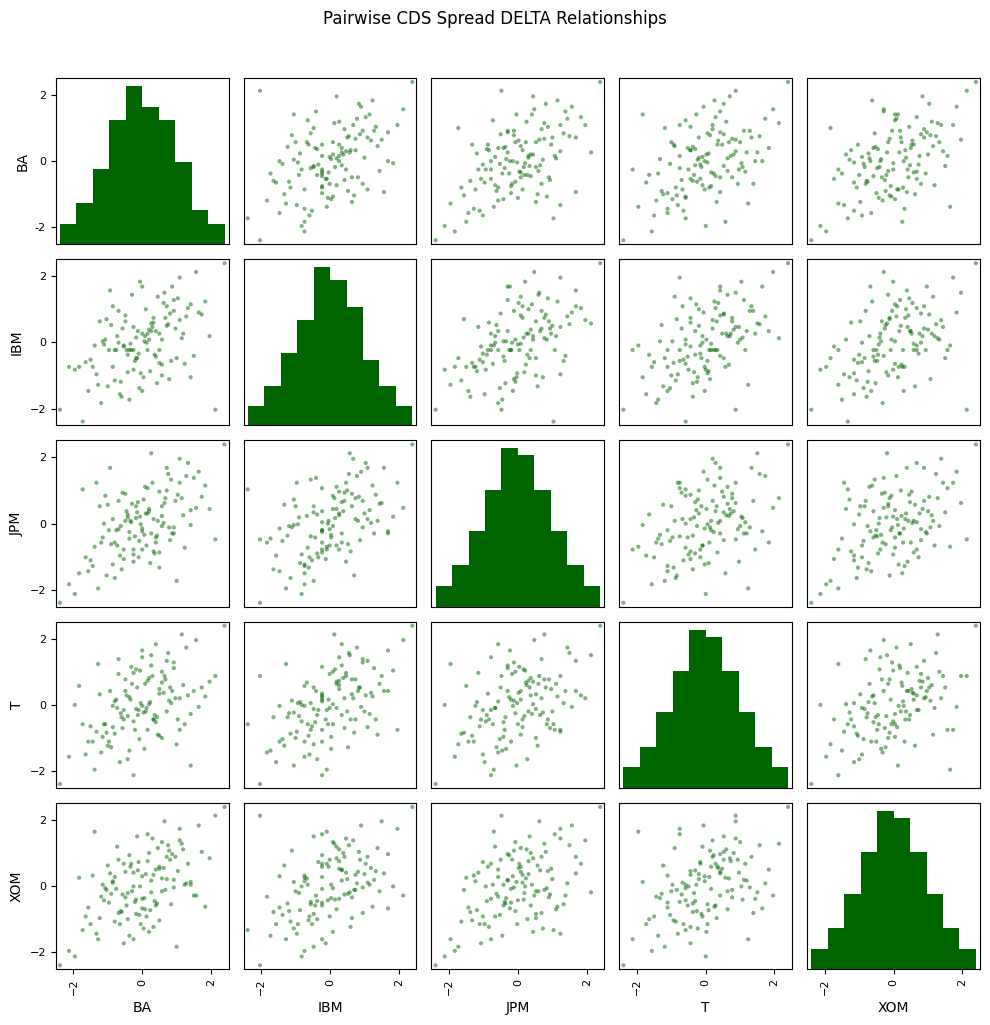

In [422]:

z_df = pd.DataFrame(
    norm.ppf(u_joint_df),
    columns=u_joint_df.columns,
    index=u_joint_df.index
)

plot_scatter_matrix(z_df, spread_measure)

In [423]:

z_corr_df = z_df.corr()

display(z_corr_df)

,BA,IBM,JPM,T,XOM
BA,1.000000,0.431250,0.498735,0.443100,0.488707
IBM,0.431250,1.000000,0.478738,0.495751,0.427940
JPM,0.498735,0.478738,1.000000,0.399742,0.439728
T,0.443100,0.495751,0.399742,1.000000,0.402186
XOM,0.488707,0.427940,0.439728,0.402186,1.000000


---

## **4. JOINT DISTRIBUTION**

In [424]:
sigma = np.array(z_corr_df)

L = np.linalg.cholesky(sigma)
Z_sim = np.random.normal(size=(n_sims, sigma.shape[0])) @ L.T
U_sim = norm.cdf(Z_sim)

In [425]:
U_sim_df = pd.DataFrame(
    U_sim,
    columns=u_joint_df.columns
)
display(U_sim_df.head())
print(U_sim_df.shape)

,BA,IBM,JPM,T,XOM
0,0.844380,0.790889,0.815810,0.293950,0.922424
1,0.664301,0.063347,0.089461,0.074367,0.110788
2,0.839907,0.930770,0.799240,0.977499,0.185577
3,0.987909,0.854291,0.864841,0.912703,0.816831
4,0.668601,0.221903,0.439896,0.407957,0.680753


(100000, 5)


---

## **5. MARGINAL HAZARD RATES**

In [426]:
# Load the current CDS curves for the tickers
current_curves_df = (
    pd.read_csv('../data/synthetic_cds_curve_2025-12-31.csv')
    .loc[lambda df: df['equity_ticker'].isin(tickers)]
    .drop(columns=(['cds_5y_spread_bps', 'hazard_rate_per_year_approx', 'pd_to_tenor_approx']))
    .pivot(
        index='equity_ticker',
        columns='tenor_years',
        values='cds_spread_bps'
    )
)

current_curves_df.columns.name = None

In [427]:
display(current_curves_df)

,1,2,3,4,5
equity_ticker,,,,,
BA,110.0,140.0,164.0,184.0,200.0
IBM,46.8,59.5,69.7,78.2,85.0
JPM,35.8,45.5,53.3,59.8,65.0
T,63.3,80.5,94.3,105.8,115.0
XOM,30.3,38.5,45.1,50.6,55.0


In [428]:
current_curves_df.loc['T'].values

array([ 63.3,  80.5,  94.3, 105.8, 115. ])

In [429]:
current_curves_df.columns.values

array([1, 2, 3, 4, 5])

In [430]:
hazard_rates = pd.DataFrame(
    index=tickers.sort(),
    columns=current_curves_df.columns
)

for ticker in tickers:

    spread_vals = current_curves_df.loc[ticker].values
    tenor_vals = current_curves_df.columns.values

    bootstrapper = BootStrapper(tenor_vals, spread_vals, recovery_rate=0.0)
    hazard_rates.loc[ticker] = bootstrapper.bootstrap()

display(hazard_rates)

,1,2,3,4,5
BA,0.01100,0.01700,0.02120,0.02440,0.02640
IBM,0.00468,0.00722,0.00901,0.01037,0.01122
JPM,0.00358,0.00552,0.00689,0.00793,0.00858
T,0.00633,0.00977,0.01219,0.01403,0.01518
XOM,0.00303,0.00467,0.00583,0.00671,0.00726


---

## **6. DEFAULT TIMES SIMULATION**

In [431]:
display(U_sim_df.head())

,BA,IBM,JPM,T,XOM
0,0.844380,0.790889,0.815810,0.293950,0.922424
1,0.664301,0.063347,0.089461,0.074367,0.110788
2,0.839907,0.930770,0.799240,0.977499,0.185577
3,0.987909,0.854291,0.864841,0.912703,0.816831
4,0.668601,0.221903,0.439896,0.407957,0.680753


In [432]:
display(hazard_rates)

,1,2,3,4,5
BA,0.01100,0.01700,0.02120,0.02440,0.02640
IBM,0.00468,0.00722,0.00901,0.01037,0.01122
JPM,0.00358,0.00552,0.00689,0.00793,0.00858
T,0.00633,0.00977,0.01219,0.01403,0.01518
XOM,0.00303,0.00467,0.00583,0.00671,0.00726


In [433]:
ttd_arr = np.ndarray(shape=(n_sims, len(tickers)), dtype=float)

for i in range(n_sims):
    for ticker in tickers:
        u = U_sim_df.loc[i, ticker]
        haz_rates = hazard_rates.loc[ticker].values
        tenors = hazard_rates.columns.values

        tau = time_to_default(u, haz_rates, tenors)
        # print(f"Sim {i}, Ticker {ticker}: u={u:.4f}, tau={tau:.4f}")

        ttd_arr[i, tickers.index(ticker)] = tau

In [434]:
ttd_df = pd.DataFrame(
    ttd_arr,
    columns=U_sim_df.columns
)

In [435]:
ttd_df["kth_default_time"] = kth_to_default_df(ttd_df, tickers, k=k)

In [436]:
display(ttd_df[ttd_df['kth_default_time'] < np.inf])

,BA,IBM,JPM,T,XOM,kth_default_time
1096,0.291387,3.566384,1.722749,2.312686,2.553611,3.566384
1914,0.031703,3.668148,0.479870,0.473566,2.173777,3.668148
2698,0.422016,0.988710,1.649992,1.109273,0.230137,1.649992
6202,0.277395,0.826426,2.919392,0.257247,4.907560,4.907560
7809,0.499664,4.144881,4.429680,2.406008,1.630660,4.429680
...,...,...,...,...,...,...
87294,2.328715,2.101600,2.768996,4.473508,4.787410,4.787410
90680,0.655280,1.197135,1.271645,4.691546,0.102482,4.691546
93371,3.317899,1.778493,2.201445,1.773322,0.905050,3.317899
96038,2.274662,1.882542,3.564452,4.240035,2.827247,4.240035


In [437]:
cds_pricer = CDSPricing(
    time_to_default=np.array(ttd_df['kth_default_time']),
    term=5.0,
    recovery_rate=recovery_rate
)

fair_price = cds_pricer.price()
fair_price

0.8761906314465481

In [438]:
prices_df = pd.concat(
    [
        ttd_df.reset_index(drop=True),
        pd.Series(
            cds_pricer.scenario_prices(),
            name="scenario_price"
        )
    ],
    axis=1
)

prices_df.index.name = None

In [439]:
# prices_df.to_csv('../output/prices_df.csv', mode='w')

In [440]:
ttd_df.to_csv('../output/ttd_df.csv', mode='w')